# Full Waveform Inversion with the Vector Reflectivity Wave Equation

In this tutorial, we perform an full waveform inversion (FWI) using forward and adjoint modeling acoustic  wave equations written in terms of P-wave velocity ($v_P$) and vector reflectivity ($\mathbf{R}$).

In [1]:
from examples.seismic.source import RickerSource, TimeAxis
from examples.seismic import setup_geometry, PointSource, Receiver, SeismicModel, plot_velocity, plot_shotrecord
from examples.seismic.preset_models import Gardners, demo_model

from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import matplotlib.pyplot as plt
from devito import *

configuration['log-level'] = 'WARNING'

## Model

In [2]:
def gen_vp(vp_list: list, shape, dtype = np.float64):
    """
    Generates a layer cake model based on a list of P-wave velocities
    """
    vp = np.ones(shape, dtype)
    nlayers = len(vp_list)
    
    for i, vpi in enumerate(vp_list):
        idx_top = i*shape[1]//nlayers
        idx_bottom = (i+1)*shape[1]//nlayers
        vp[:, idx_top : idx_bottom] *= vpi
    
    return vp

In [ ]:

def create_model(gaussian_smooth_sigma=None):
    nx = 200
    nz = 120

    shape = (nx, nz)
    spacing = (10., 10.)
    origin = (0., 0.)
    nbl = 50
    space_order = 8
    dtype = np.float32

    # vp_list = [1.5, 3.5, 4.0]
    vp_list = [1.5, 3.5]

    # Model physical parameters:
    vp = gen_vp(vp_list, shape, dtype)
    b = Gardners(vp, False)

    model = SeismicModel(
        origin=origin, 
        spacing=spacing, 
        shape=shape, 
        space_order=space_order, 
        vp=vp,
        b=b,
        nbl=nbl,
        bcs='damp',
        dtype=dtype,
    )

    if gaussian_smooth_sigma:
        gaussian_smooth(model.vp.data, gaussian_smooth_sigma)
        # gaussian_smooth(model.r[0].data, gaussian_smooth_sigma)
        # gaussian_smooth(model.r[1].data, gaussian_smooth_sigma)
    
    return model

# def create_model(vp_bkg, vp_anom, model=None):
#     nx = 101
#     nz = 101

#     shape = (nx, nz)
#     spacing = (10., 10.)
#     origin = (0., 0.)
#     nbl = 40
#     space_order = 8
#     dtype = np.float32

#     # Model physical parameters:
#     if model:
#         return demo_model('circle-isotropic', vp_circle=vp_anom, vp_background=vp_bkg,
#                     origin=origin, shape=shape, spacing=spacing, nbl=nbl, grid = model.grid)

#     return demo_model('circle-isotropic', vp_circle=vp_anom, vp_background=vp_bkg,
#                     origin=origin, shape=shape, spacing=spacing, nbl=nbl)

In [4]:
def plot_model(model, title=""):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    
    fig.suptitle(title, fontsize=28, y=1.05)

    slc = (slice(model.nbl, -model.nbl),) * 2

    im_vp = ax[0].imshow(np.transpose(model.vp.data[slc]), **plt_options_model)
    fig.colorbar(im_vp, ax=ax[0])
    ax[0].set_title("$V_P$ (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    plt_options_model.update({'cmap': 'grey'})
    im_rx = ax[1].imshow(np.transpose(model.r[0].data[slc]), **plt_options_model)
    fig.colorbar(im_rx, ax=ax[1])
    ax[1].set_title("$R_x$", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    im_rz = ax[2].imshow(np.transpose(model.r[1].data[slc]), **plt_options_model)
    fig.colorbar(im_rz, ax=ax[2])
    ax[2].set_title(r"$R_z$", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

In [5]:
sigma = 6

model_true = create_model()
model0 = create_model(sigma)

# model_true = create_model()
# model0 = create_model(model_true)

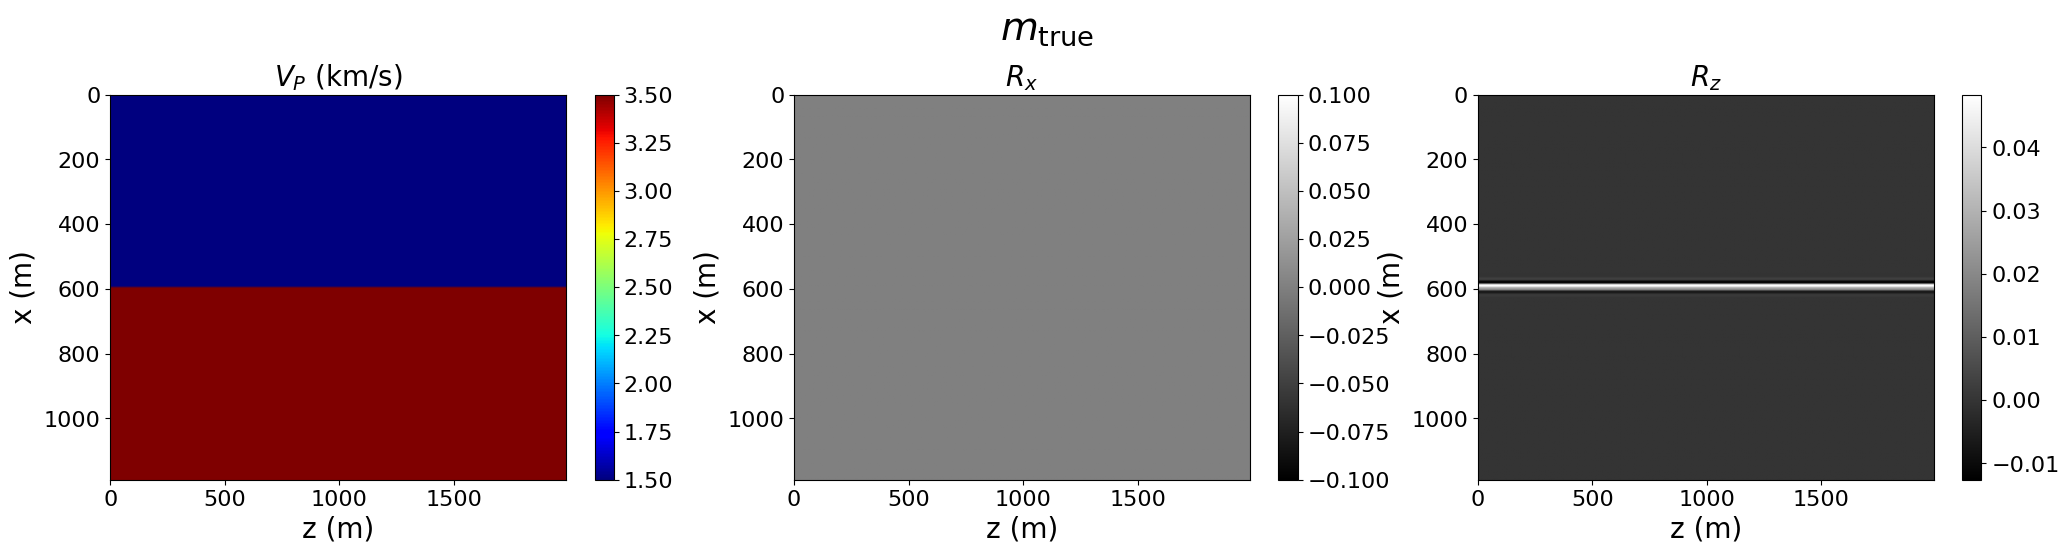

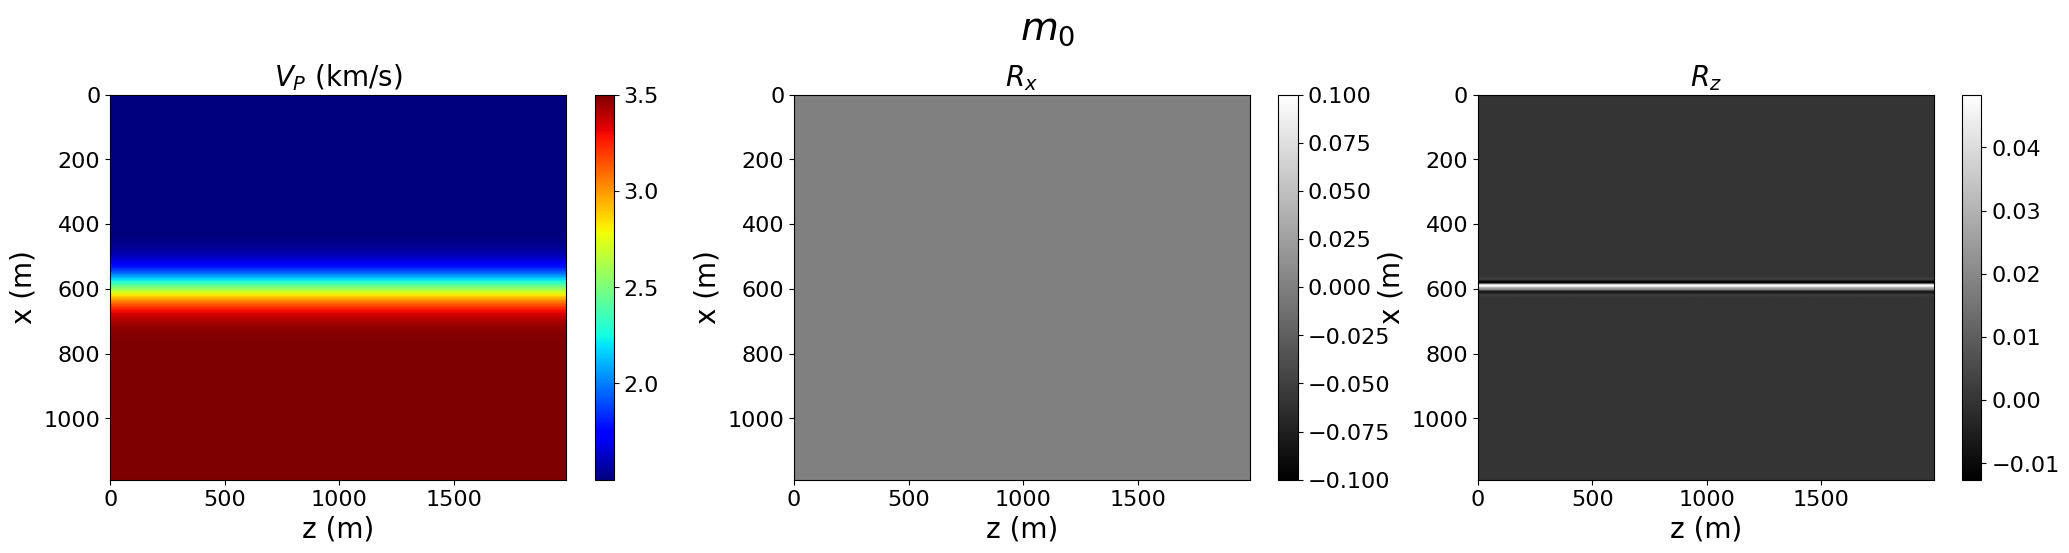

In [6]:
plot_model(model_true, '$m_{\\mathrm{true}}$')
plot_model(model0, '$m_0$')

## Aquisition

In [7]:
def new_src(model, geometry, src_pos):
    src = RickerSource(name='src', grid=model.grid, f0=geometry.f0, 
                       time_range=geometry.time_axis)

    src.coordinates.data[:, 0] = src_pos[0]
    src.coordinates.data[:, 1] = src_pos[1]
    
    return src


def new_rec(model, geometry,rec_depth, nrec):
    rec = Receiver(name='rec', grid=model.grid, npoint=nrec,
                   time_range=geometry.time_axis)

    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nrec)
    rec.coordinates.data[:, 1] = rec_depth
    
    return rec

In [8]:
f0 = 0.010  # peak/dominant frequency

t0, tn = 0., 1100.
time_range = TimeAxis(start=t0, stop=tn, step=model_true.critical_dt)

geometry = setup_geometry(model_true, tn, f0=f0)

## Forward modelling

In [9]:
def plot_wavefield(u, geometry, src_pos, model, title=None, t0=0, tn=-1, rec_pos=None, annotation_callback=None):
    """
    Exibe o campo de onda em 4 instantes distribuídos em um período determinado por `t0` e `tn`
    """
    shape_pad = np.array(model.shape)
    origin_pad = model.origin
    extent_pad = tuple([s*(n-1) for s, n in zip(model.spacing, shape_pad)])

    # Note: flip direction of second dimension to make the plot positive downwards
    plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
                origin_pad[1] + extent_pad[1], origin_pad[1]]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
    fig.suptitle(title, size=20, y=1.05)
    isfirst = True
    last_ax = None
    last_plot = None

    t0 = t0 - geometry.t0
    tn = tn - geometry.t0
    dt = geometry.dt

    snapshots = None
    if tn < 0:
        idx_min = max(int(np.round(t0/dt)), 0)
        snapshots = np.linspace(idx_min, geometry.nt - 1, num=4, dtype=np.int32)
    else:
        idx_min = max(int(np.round(t0/dt)), 0)
        idx_max = min(int(np.round(tn/dt)), geometry.nt - 1)
        snapshots = np.linspace(idx_min, idx_max, num=4, dtype=np.int32)


    udata = u.data
    amax = np.max(np.abs(udata[snapshots[-1], :, :]))

    for count, ax in enumerate(axes.ravel()):
        snapshot = snapshots[count]
        last_plot = ax.imshow(udata[snapshot, model.nbl:-model.nbl, model.nbl:-model.nbl].T,
                              cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(src_pos[0], src_pos[1], 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        
        if type(rec_pos) != type(None):
            ax.plot(rec_pos[0], rec_pos[1], 'green', linestyle='None', marker='v',
                    markersize=8, label="Receiver")
            
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=11)

        ax.set_title("t=%.2fms" % (snapshot*dt + geometry.t0), fontsize=12)
        ax.set_xlabel("x (m)", fontsize=12)
        isfirst and ax.set_ylabel("z (m)", fontsize=12)
        isfirst = False
        last_ax = ax

    divider = make_axes_locatable(last_ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(last_plot, cax=cax)

    if annotation_callback:
        annotation_callback(fig, axes)

In [10]:
def forward(model, geometry, src, rec, save_snaps=False):
    u = TimeFunction(name='u', grid=model.grid, time_order=2,
                    space_order=model.space_order, staggered=NODE,
                    save = save_snaps and geometry.nt or None)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - u.laplace + (- 1/vp*grad(vp) + 2*r).T * grad(u) + model.damp * u.dt

    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    # src_term = src.inject(field=u.forward, expr= - src * dt**2 * vp**3/2)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u

In [11]:
src_pos = np.zeros((1, 2), dtype=model_true.dtype)
src_pos[0, 0] = model_true.domain_size[0] * .5

nrec = model_true.shape[0]
rec_depth = 0

src = new_src(model_true, geometry, src_pos[0])
rec = new_rec(model_true, geometry, rec_depth, nrec)
rec0 = new_rec(model0, geometry, rec_depth, nrec)
u = forward(model_true, geometry, src, rec, save_snaps=True)
u0 = forward(model0, geometry, src, rec0, save_snaps=True)

In [12]:
f = TimeFunction(name='f', grid=model_true.grid, space_order=model_true.space_order, save=geometry.nt, time_order=2)

vp = model_true.vp
# test_grad = -2/vp**3 * u.dt2 + (u/vp).laplace + 1/vp * grad(vp).T * grad(u)
# test_grad = -2/vp**3 * u.dt2 + (u/vp).laplace + 1/vp * (vp.dx * u.dx + vp.dy * u.dy)
test_grad = -2/vp**3 * u.dt2 + 1/vp * (vp.dx * u.dx + vp.dy * u.dy)
stencil = Eq(f, test_grad)
Operator([stencil])(dt=geometry.dt)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.309944, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

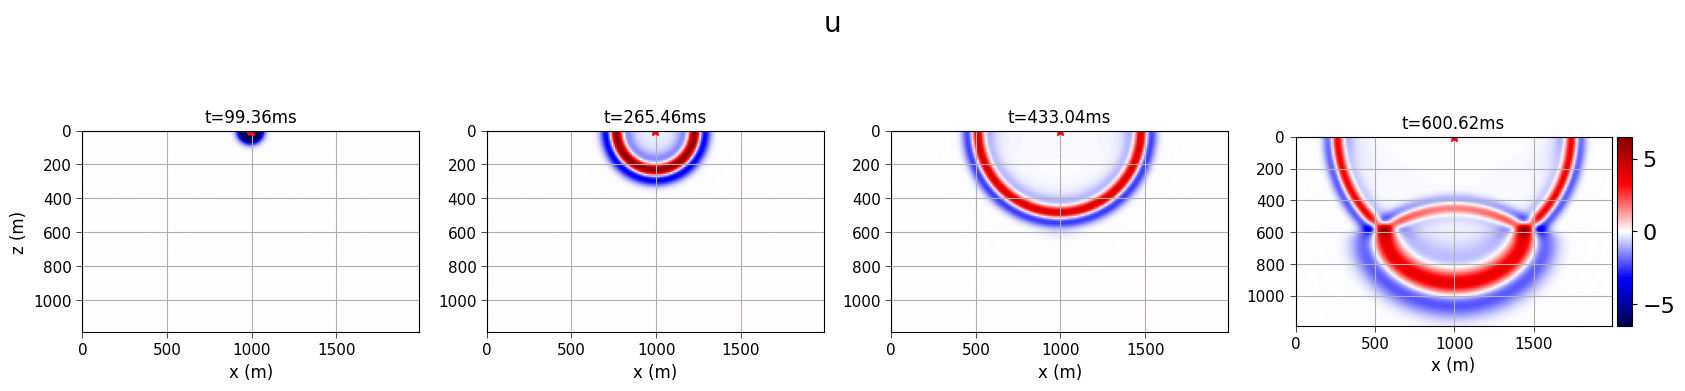

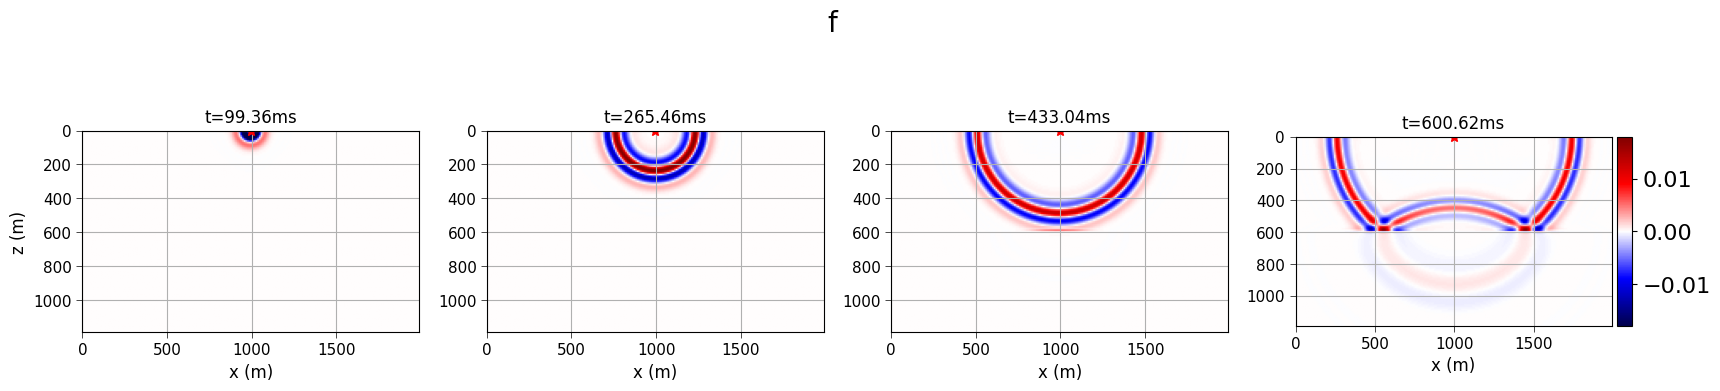

In [13]:
plot_wavefield(u, geometry, src_pos.T, model_true, title='u', t0=100, tn=600)
plot_wavefield(f, geometry, src_pos.T, model_true, title='f', t0=100, tn=600)

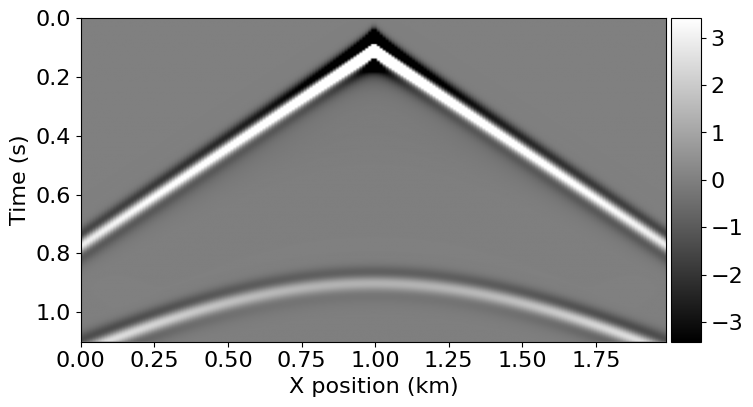

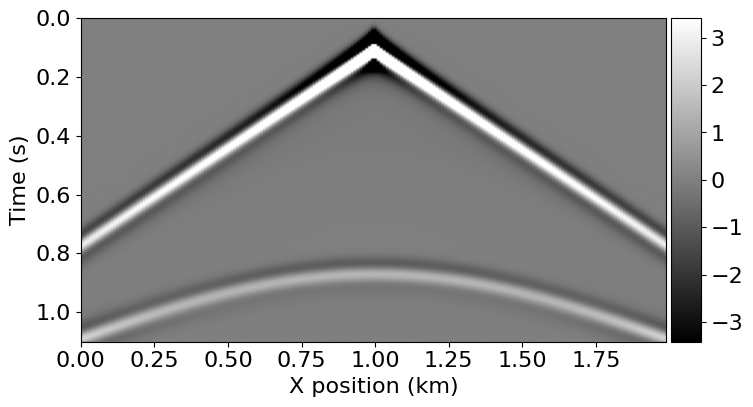

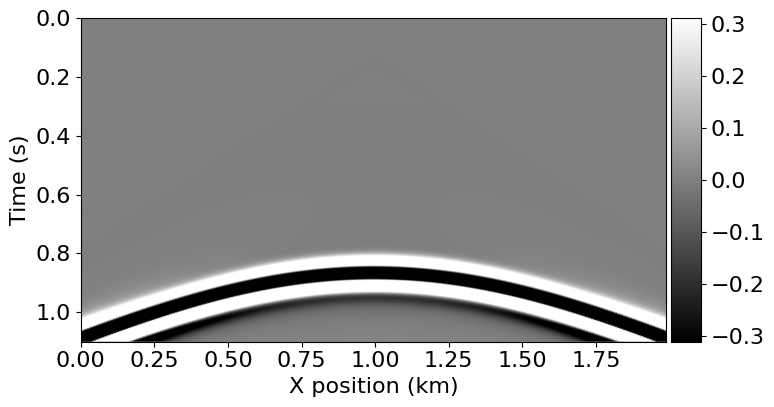

In [14]:
plot_shotrecord(rec.data, model_true, t0, tn)
plot_shotrecord(rec0.data, model0, t0, tn)
plot_shotrecord(rec.data - rec0.data, model0, t0, tn)

## Gradient

Gradient w.r.t. $\mathbf{m}$ for the functional

$$
J(\mathbf{m}) = \frac{1}{2}|| G(\mathbf{m}) - \mathbf{d}_{\mathrm{obs}} ||_2^2
$$

In [15]:
def GradientOperator(model, geometry, rec):
    u = TimeFunction(name='u', grid=model.grid, space_order=model.space_order, 
                           time_order=2, save=geometry.nt)
    v = TimeFunction(name='v', grid=model.grid, space_order=model.space_order, 
                           time_order=2)
    
    dJdvp = Function(name='dJdvp', grid=model.grid, space_order=model.space_order)
    dJdR = VectorFunction(name='dJdR', grid=model.grid, space_order=model.space_order)

    s = model.grid.stepping_dim.spacing

    m = model.m
    vp = model.vp
    r = model.r

    pde_v = m * v.dt2 - v.laplace - div((-grad(vp)/vp + 2*r) * v, .5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde_v, v.backward))]

    # grad_update = [
    #     Inc(
    #         dJdvp,
    #         # (-2/vp**3 * u.dt2 + (grad(vp)/vp).T * grad(u) + (u/vp).laplace)*v
    #         # (-2/vp**3 * u.dt2 + 1/vp * (vp.dx * u.dx + vp.dy * u.dy) + (u/vp).laplace)*v
    #         -(-2/vp**3 * u.dt2 + 1/vp * (vp.dx * u.dx + vp.dy * u.dy))*v
    #         # (-2/vp**3 * u.dt2 + (grad(vp)/vp).T * grad(u))*v
    #     ),
    #     Inc(
    #         dJdR, -2*grad(u) * v
    #     )
    # ]
    grad_update = [
        # Eq(
        #     dJdvp, dJdvp - (-2/vp**3 * u.dt2 + 1/vp * (vp.dx * u.dx + vp.dy * u.dy) - 1/vp * u.laplace)*v
        # ),
        Eq(
            dJdvp, dJdvp - (-3/vp**3 * u.dt2 + 1/vp * (vp.dx * u.dx + vp.dy * u.dy))*v
        ),
        Eq(
            dJdR, dJdR-2*grad(u) * v
        )
    ]

    # Construct expression to inject receiver values
    rec_term = rec.inject(field=v.backward, expr=rec * s**2 / m)

    return Operator(stencil + grad_update + rec_term, 
             subs=model.spacing_map, name='Gradient')

## FWI loop

In [16]:
def Barzilai_Borwein_step(yk, sk) -> float:
    term1 = np.dot(sk.reshape(-1), sk.reshape(-1))
    term2 = np.dot(sk.reshape(-1), yk.reshape(-1))
    term3 = np.dot(yk.reshape(-1), yk.reshape(-1))
    
    # term2 += (term2 == 0) * 1e-9

    abb1 = term1 / term2
    abb2 = term2 / term3
    
    # abb1 += (abb1 == 0) * 1e-9
    
    abb3 = abb2  / abb1

    return (abb3 > 0 and abb3 < 1) and abb2 or abb1

In [17]:
def run(model_true, model_i, geometry, source_positions, rec_depth, nrec, niter):
    dJdvp = Function(name='dJdvp', grid=model_true.grid, space_order=model_true.space_order)
    dJdR = VectorFunction(name='dJdR', grid=model_true.grid, space_order=model_true.space_order)

    nshots = source_positions.shape[0]

    objective = np.zeros((niter,))

    cached_op = None
    vp_models = [1*model_i.vp.data]
    
    vp_i_1 = np.zeros_like(model_true.vp.data)
    # rx_i_1 = np.zeros_like(model_true.vp.data)
    # rz_i_1 = np.zeros_like(model_true.vp.data)

    vp_grad_i = np.zeros_like(model_true.vp.data)
    # rx_grad_i = np.zeros_like(model_true.vp.data)
    # rz_grad_i = np.zeros_like(model_true.vp.data)
    
    for it in range(niter):
        print('Iteration  %d / %d' % (it+1, niter))

        vp_grad_i_1 = vp_grad_i
        # rx_grad_i_1 = rx_grad_i
        # rz_grad_i_1 = rz_grad_i

        vp_grad_i = np.zeros_like(model_true.vp.data)
        # rx_grad_i = np.zeros_like(model_true.vp.data)
        # rz_grad_i = np.zeros_like(model_true.vp.data)
        
        for i in range(nshots):
            print('\tShot %d / %d' % (i+1, nshots))
            
            src_pos = source_positions[i, :]
            src = new_src(model_true, geometry, src_pos)
            
            dcalc = new_rec(model_true, geometry, rec_depth, nrec)
            dobs = new_rec(model_true, geometry, rec_depth, nrec)
            residual = new_rec(model_true, geometry, rec_depth, nrec)

            forward(model_true, geometry, src, dobs)
            u = forward(model_i, geometry, src, dcalc, save_snaps=True)

            residual.data[:] = dcalc.data[:] - dobs.data[:]

            objective[it] += norm(residual)**2/2

            if not cached_op:
                cached_op = GradientOperator(model_i, geometry, residual)

            op_grad = cached_op
            # op_grad = GradientOperator(model_i, geometry, residual)

            op_grad(
                u=u, 
                dJdvp=dJdvp, dJdR_x=dJdR[0], dJdR_y=dJdR[1], rec=residual,
                vp = model_i.vp, r_x = model_i.r[0], r_y = model_i.r[1],
                dt = model_i.critical_dt
            )

            # plt.figure()
            # plt.plot(geometry.time_axis.time_values, dtrue.data[:,nrec//2], label='true')
            # plt.plot(geometry.time_axis.time_values, dcalc.data[:,nrec//2], label='calc')
            # plt.plot(geometry.time_axis.time_values, residual.data[:,nrec//2], label='residual')
            # plt.legend()
            # plt.show()
            # plt.figure()
            # plt.imshow(dJdvp.data[model_i.nbl:-model_i.nbl, model_i.nbl:-model_i.nbl].T, cmap='grey')
            # plt.title(f'Shot {i+1} / {nshots}')
            # plt.colorbar()
            # plt.show()

            vp_grad_i += dJdvp.data[:]
            dJdvp.data[:] = 0
            # rx_grad_i[:] += dJdR[0].data[:]
            # rz_grad_i[:] += dJdR[1].data[:]


        alpha_vp = alpha_rx = alpha_rz = 0
        # alpha_vp = .05/np.max(np.abs(vp_grad_i))
        # if it == 0:
        alpha_vp = .05/np.max(np.abs(vp_grad_i))
            # alpha_rx = .05/np.max(rx_grad_i)
            # alpha_rz = .05/np.max(rz_grad_i)
        # else:
        #     vp_yk = vp_grad_i - vp_grad_i_1
        #     # rx_yk = rx_grad_i - rx_grad_i_1
        #     # rz_yk = rz_grad_i - rz_grad_i_1

        #     vp_sk = model_i.vp.data[:] - vp_i_1
        #     # rx_sk = model_i.r[0].data[:] - rx_i_1
        #     # rz_sk = model_i.r[1].data[:] - rz_i_1

        #     alpha_vp = Barzilai_Borwein_step(vp_yk, vp_sk)
            # alpha_rx = Barzilai_Borwein_step(rx_yk, rx_sk)
        #     # alpha_rz = Barzilai_Borwein_step(rz_yk, rz_sk)

        plt.figure()
        plt.imshow(vp_grad_i[model_i.nbl:-model_i.nbl, model_i.nbl:-model_i.nbl].T, cmap='grey')
        plt.title(f'Iteration {it+1} / {niter}')
        plt.colorbar()
        plt.show()

        vp_i_1[:] = 1*model_i.vp.data[:]
        # rx_i_1[:] = 1*model_i.r[0].data[:]
        # rz_i_1[:] = 1*model_i.r[1].data[:]


        model_i.vp.data[:] -= alpha_vp*vp_grad_i
        vp_models.append(1*model_i.vp.data[:])
        print(f'\tJ = {objective[it]}')
        # model_i.r[0].data[:] -= alpha_rx*dJdR[0].data[:]
        # model_i.r[1].data[:] -= alpha_rz*dJdR[1].data[:]

        assert not np.isnan(objective[it])
    
    return objective, vp_models

In [18]:
nshots = 20
niter = 5
rec_depth = 0
source_positions = np.empty((nshots, 2), dtype=np.float32)
source_positions[:, 0] = np.linspace(0., model_true.shape[0]*model_true.spacing[0],
                                     num=nshots)
source_positions[:, 1] = 10.

Iteration  1 / 5
	Shot 1 / 20
	Shot 2 / 20
	Shot 3 / 20
	Shot 4 / 20
	Shot 5 / 20
	Shot 6 / 20
	Shot 7 / 20
	Shot 8 / 20
	Shot 9 / 20
	Shot 10 / 20
	Shot 11 / 20
	Shot 12 / 20
	Shot 13 / 20
	Shot 14 / 20
	Shot 15 / 20
	Shot 16 / 20
	Shot 17 / 20
	Shot 18 / 20
	Shot 19 / 20
	Shot 20 / 20


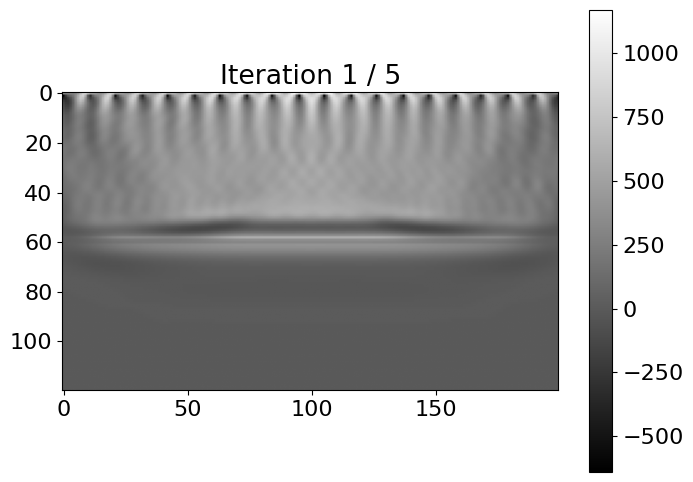

	J = 242779.51953125
Iteration  2 / 5
	Shot 1 / 20
	Shot 2 / 20
	Shot 3 / 20
	Shot 4 / 20
	Shot 5 / 20
	Shot 6 / 20
	Shot 7 / 20
	Shot 8 / 20
	Shot 9 / 20
	Shot 10 / 20
	Shot 11 / 20
	Shot 12 / 20
	Shot 13 / 20
	Shot 14 / 20
	Shot 15 / 20
	Shot 16 / 20
	Shot 17 / 20
	Shot 18 / 20
	Shot 19 / 20
	Shot 20 / 20


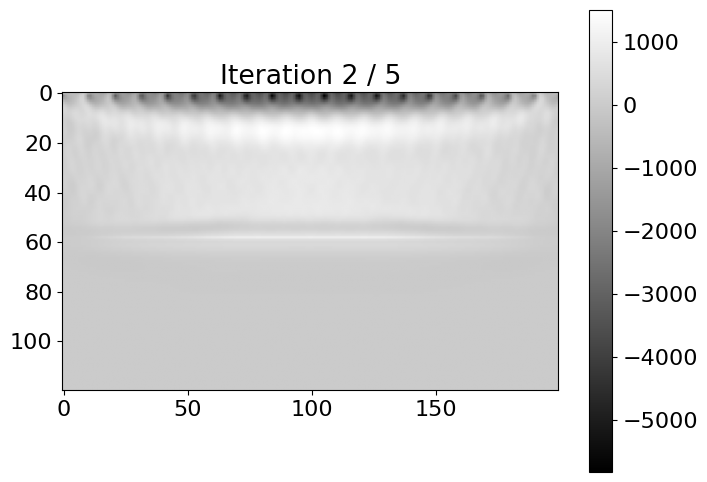

	J = 212820.4755859375
Iteration  3 / 5
	Shot 1 / 20
	Shot 2 / 20
	Shot 3 / 20
	Shot 4 / 20
	Shot 5 / 20
	Shot 6 / 20
	Shot 7 / 20
	Shot 8 / 20
	Shot 9 / 20
	Shot 10 / 20
	Shot 11 / 20
	Shot 12 / 20
	Shot 13 / 20
	Shot 14 / 20
	Shot 15 / 20
	Shot 16 / 20
	Shot 17 / 20
	Shot 18 / 20
	Shot 19 / 20
	Shot 20 / 20


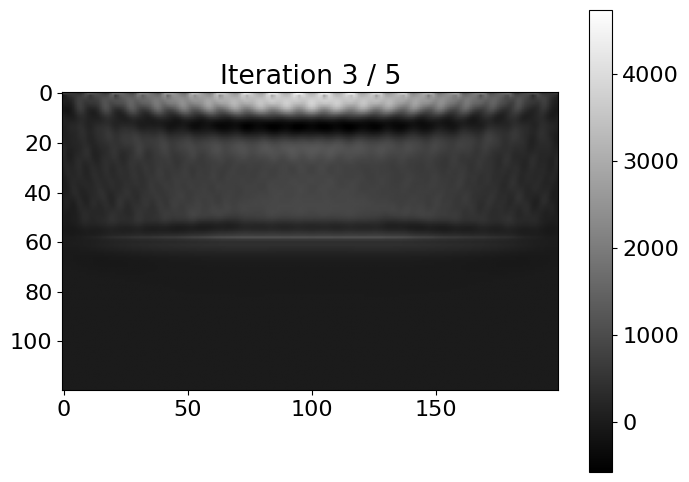

	J = 199611.611328125
Iteration  4 / 5
	Shot 1 / 20
	Shot 2 / 20
	Shot 3 / 20
	Shot 4 / 20
	Shot 5 / 20
	Shot 6 / 20
	Shot 7 / 20
	Shot 8 / 20
	Shot 9 / 20
	Shot 10 / 20
	Shot 11 / 20
	Shot 12 / 20
	Shot 13 / 20
	Shot 14 / 20
	Shot 15 / 20
	Shot 16 / 20
	Shot 17 / 20
	Shot 18 / 20
	Shot 19 / 20
	Shot 20 / 20


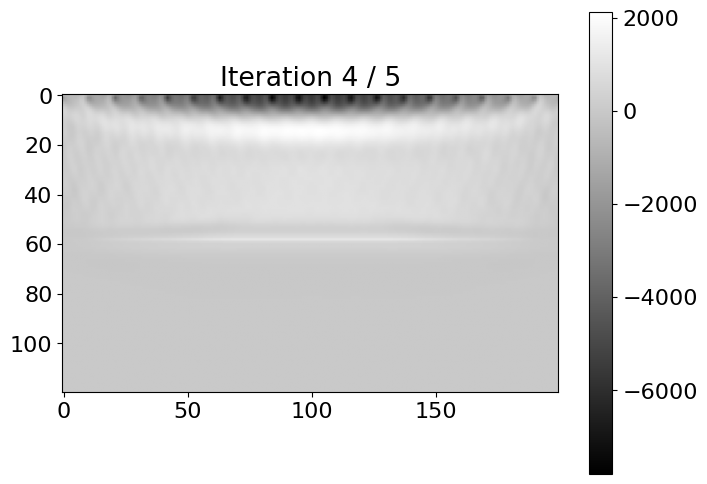

	J = 179707.818359375
Iteration  5 / 5
	Shot 1 / 20
	Shot 2 / 20
	Shot 3 / 20
	Shot 4 / 20
	Shot 5 / 20
	Shot 6 / 20
	Shot 7 / 20
	Shot 8 / 20
	Shot 9 / 20
	Shot 10 / 20
	Shot 11 / 20
	Shot 12 / 20
	Shot 13 / 20
	Shot 14 / 20
	Shot 15 / 20
	Shot 16 / 20
	Shot 17 / 20
	Shot 18 / 20
	Shot 19 / 20
	Shot 20 / 20


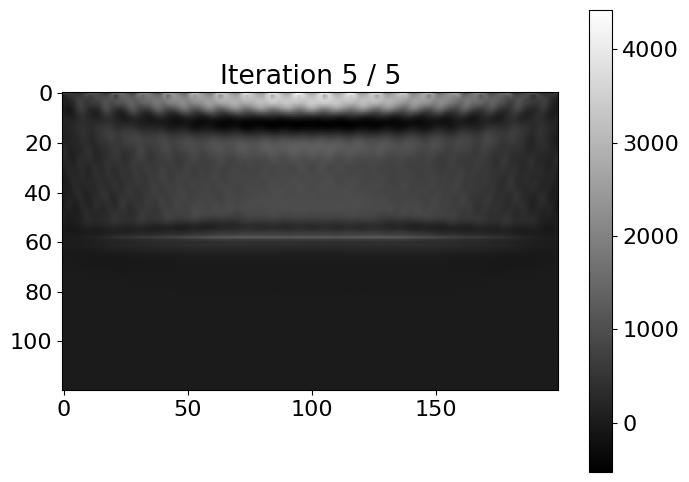

	J = 148126.74072265625


In [19]:
objective, vp_models = run(model_true, model0, geometry, source_positions, 0, model_true.shape[0], niter)

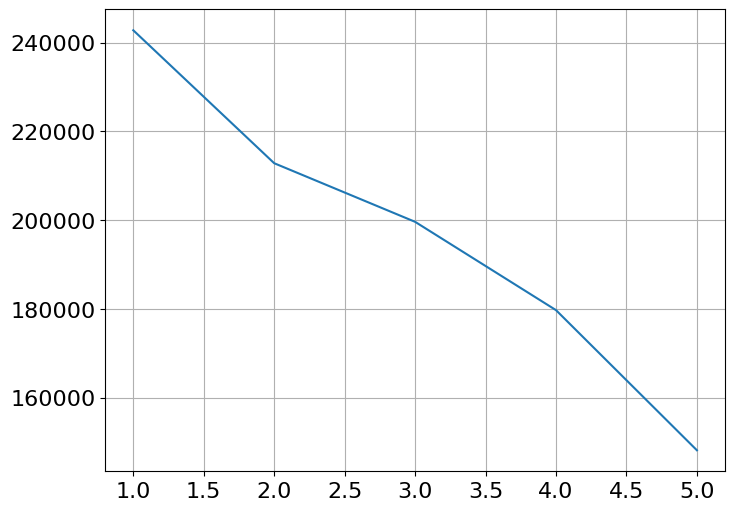

In [20]:
plt.plot(np.linspace(1, niter, num=niter), objective)
plt.grid()

In [21]:
objective[-1]

np.float64(148126.74072265625)

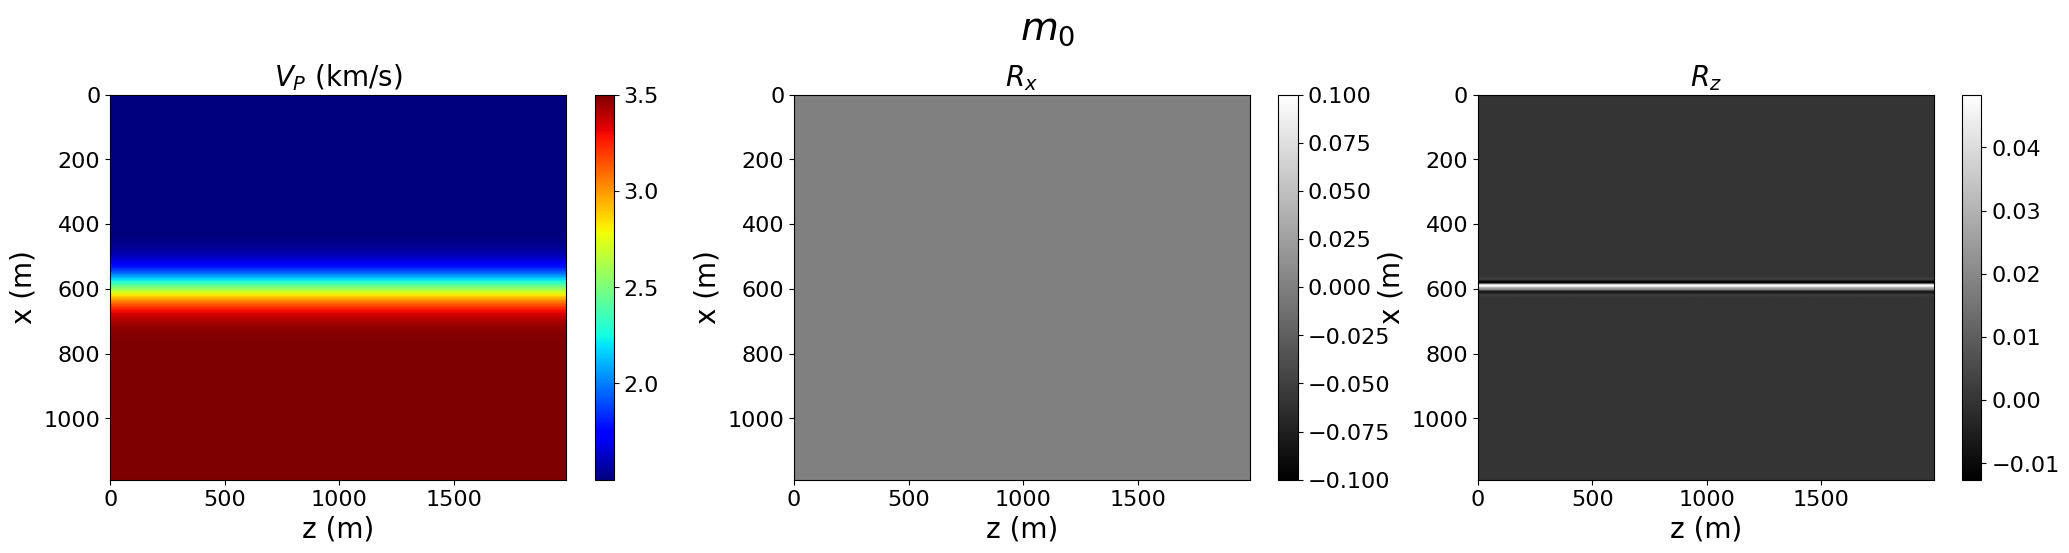

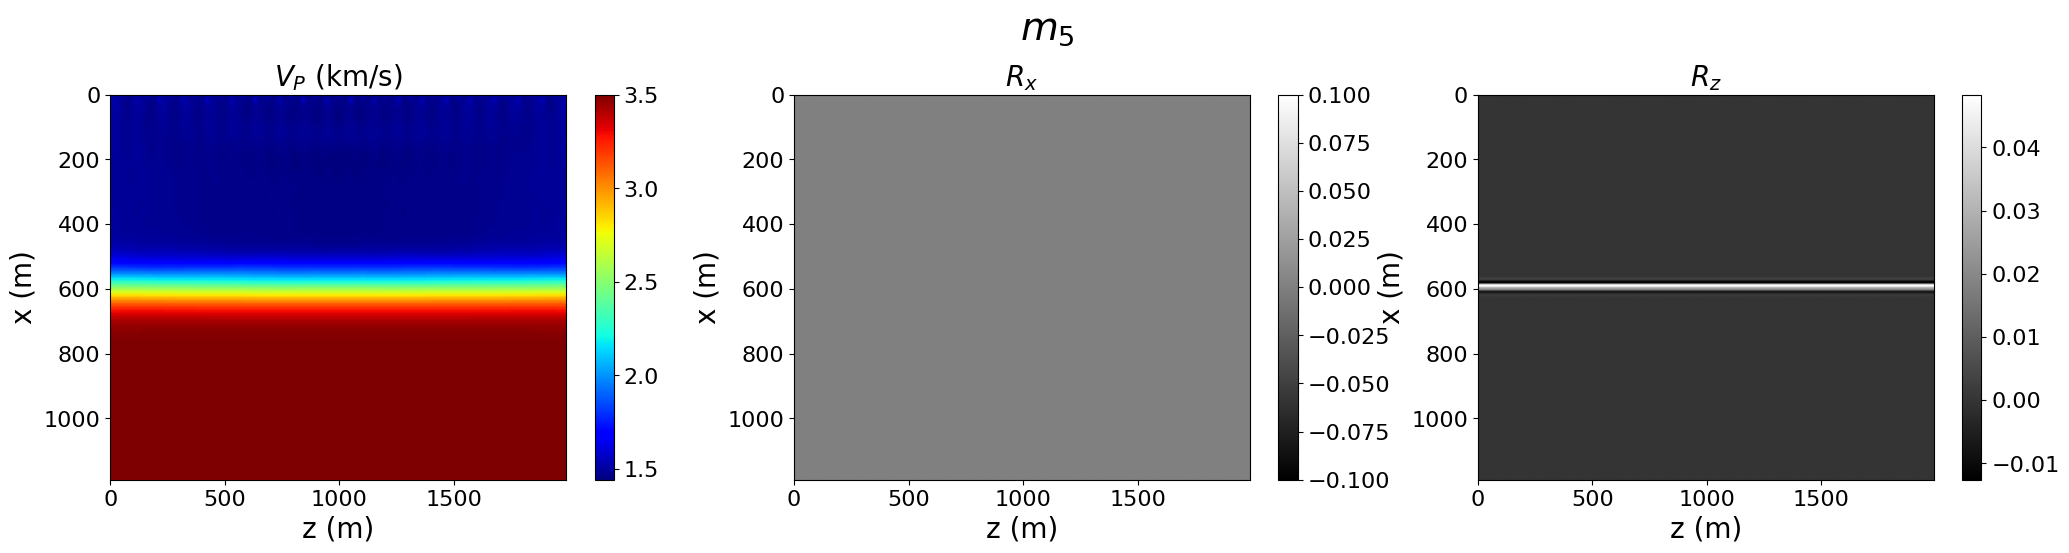

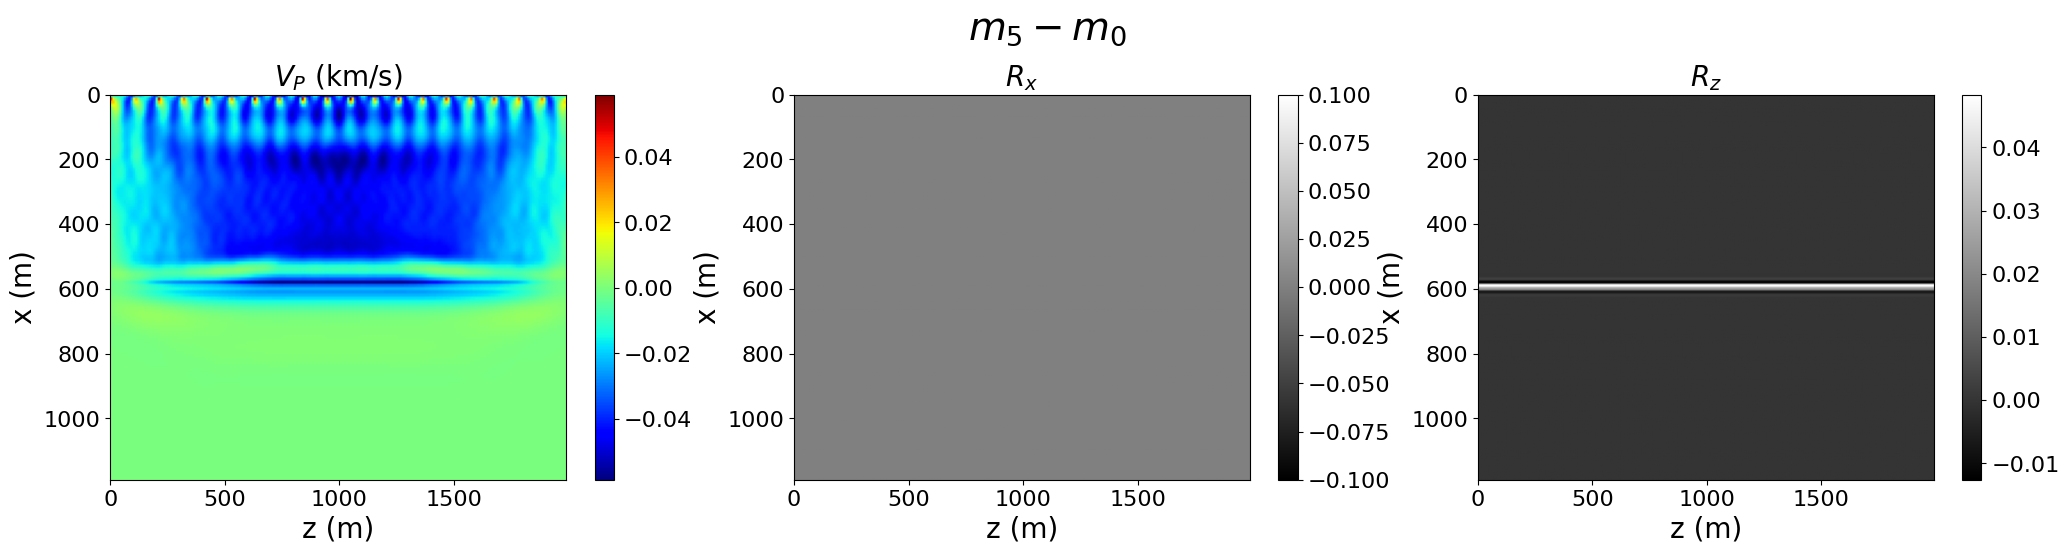

In [23]:
model0.vp.data[:] = vp_models[0]
plot_model(model0, '$m_{0}$')
model0.vp.data[:] = vp_models[-1]
plot_model(model0, '$m_{' + str(niter) + '}$')
model0.vp.data[:] = vp_models[-1] - vp_models[0]
plot_model(model0, '$m_{' + str(niter) + '} - m_0$')